In [4]:
from skimage.transform   import iradon, radon, resize   # algorithms for image processing
from skimage.data        import brain
import numpy             as np                         
import matplotlib.pyplot as plt                         # library for data visualisation

In [5]:
plt.rcParams['figure.dpi'] = 600    # Improve figure quality
nxd    = 64                         # nxd is the number of pixels in the x dimension of the reconstructed image
nphi   = int(nxd*1.0)               # nphi is the number of view angles
azi_angles = np.linspace(0.0,180.0, nphi, endpoint=False) # nphi values between 0.0 and 180.0, excluding endpoint

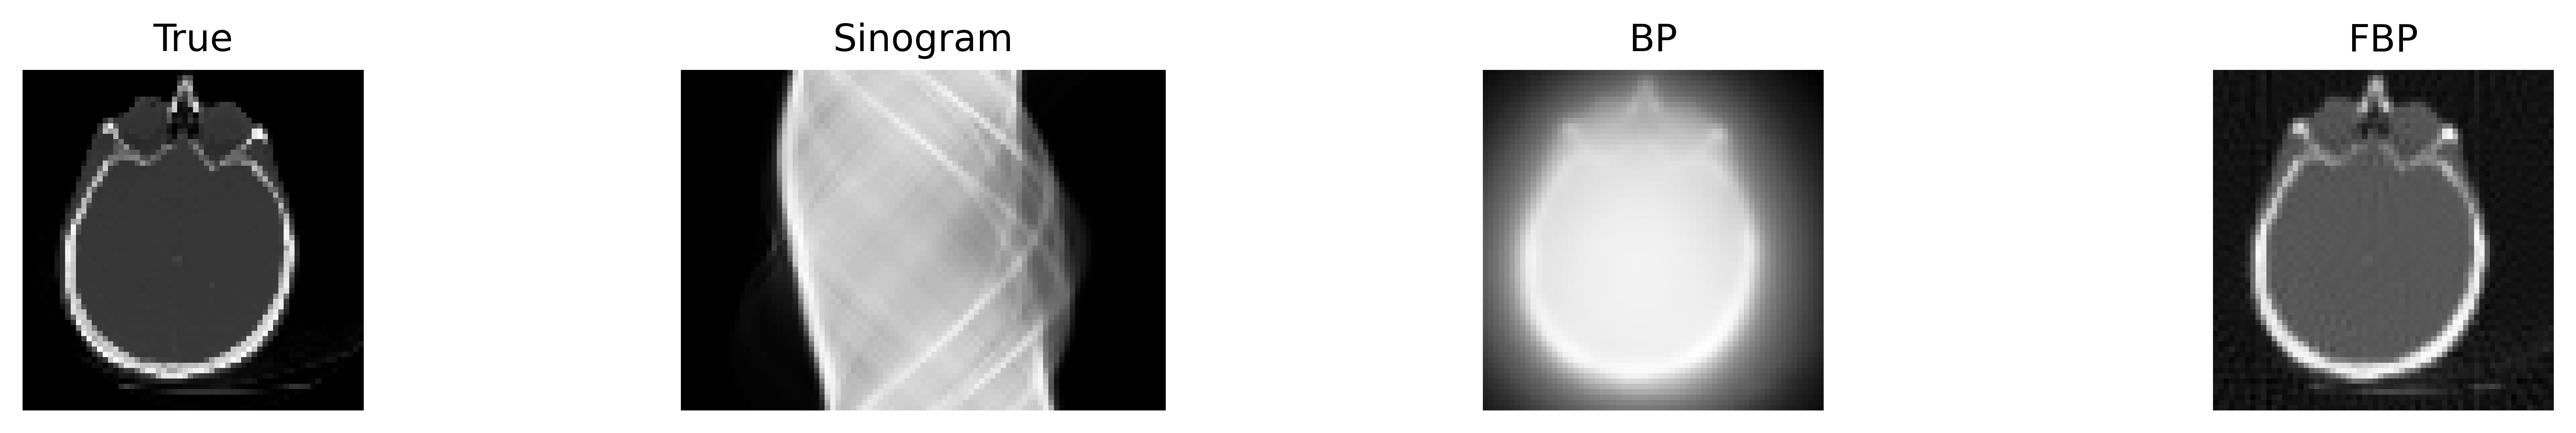

In [6]:
brainimage       = brain()          # a range of brain CT slices
true_object_np   = resize(brainimage[5,30:-1,:-30], (nxd,nxd), anti_aliasing=False)
true_sinogram_np = radon(true_object_np, azi_angles, circle=False)

fig1, ax = plt.subplots(1,4, figsize=(16,2)) # No. rows, cols,  figsize Width,Height (inches)
ax[0].imshow(true_object_np,     cmap='Greys_r'); ax[0].set_title('True');     ax[0].set_axis_off() 
ax[1].imshow(true_sinogram_np.T, cmap='Greys_r'); ax[1].set_title('Sinogram'); ax[1].set_axis_off()   

bp_recon  = iradon(true_sinogram_np,  output_size=nxd, filter_name =  None,  circle=False)    # Plain backprojection
fbp_recon = iradon(true_sinogram_np,  output_size=nxd, filter_name = 'ramp', circle=False)  # Basic ramp-filtered FBP
ax[2].imshow(bp_recon,  cmap='Greys_r'); ax[2].set_title('BP');  ax[2].set_axis_off()
ax[3].imshow(fbp_recon, cmap='Greys_r'); ax[3].set_title('FBP'); ax[3].set_axis_off()

In [7]:
import torch, torch.nn   as nn         
torch.manual_seed(0);  # Fix the random numbers for torch  #print(torch.rand(1))
device     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device)  # Use GPU if available

cuda:0


In [8]:
#-------------------------TORCH TO NUMPY CONVERTORS-------------------------------------------
def torch_to_np(torch_array):   return np.squeeze(torch_array.detach().cpu().numpy())
def np_to_torch(np_array):      return torch.from_numpy(np_array).float()

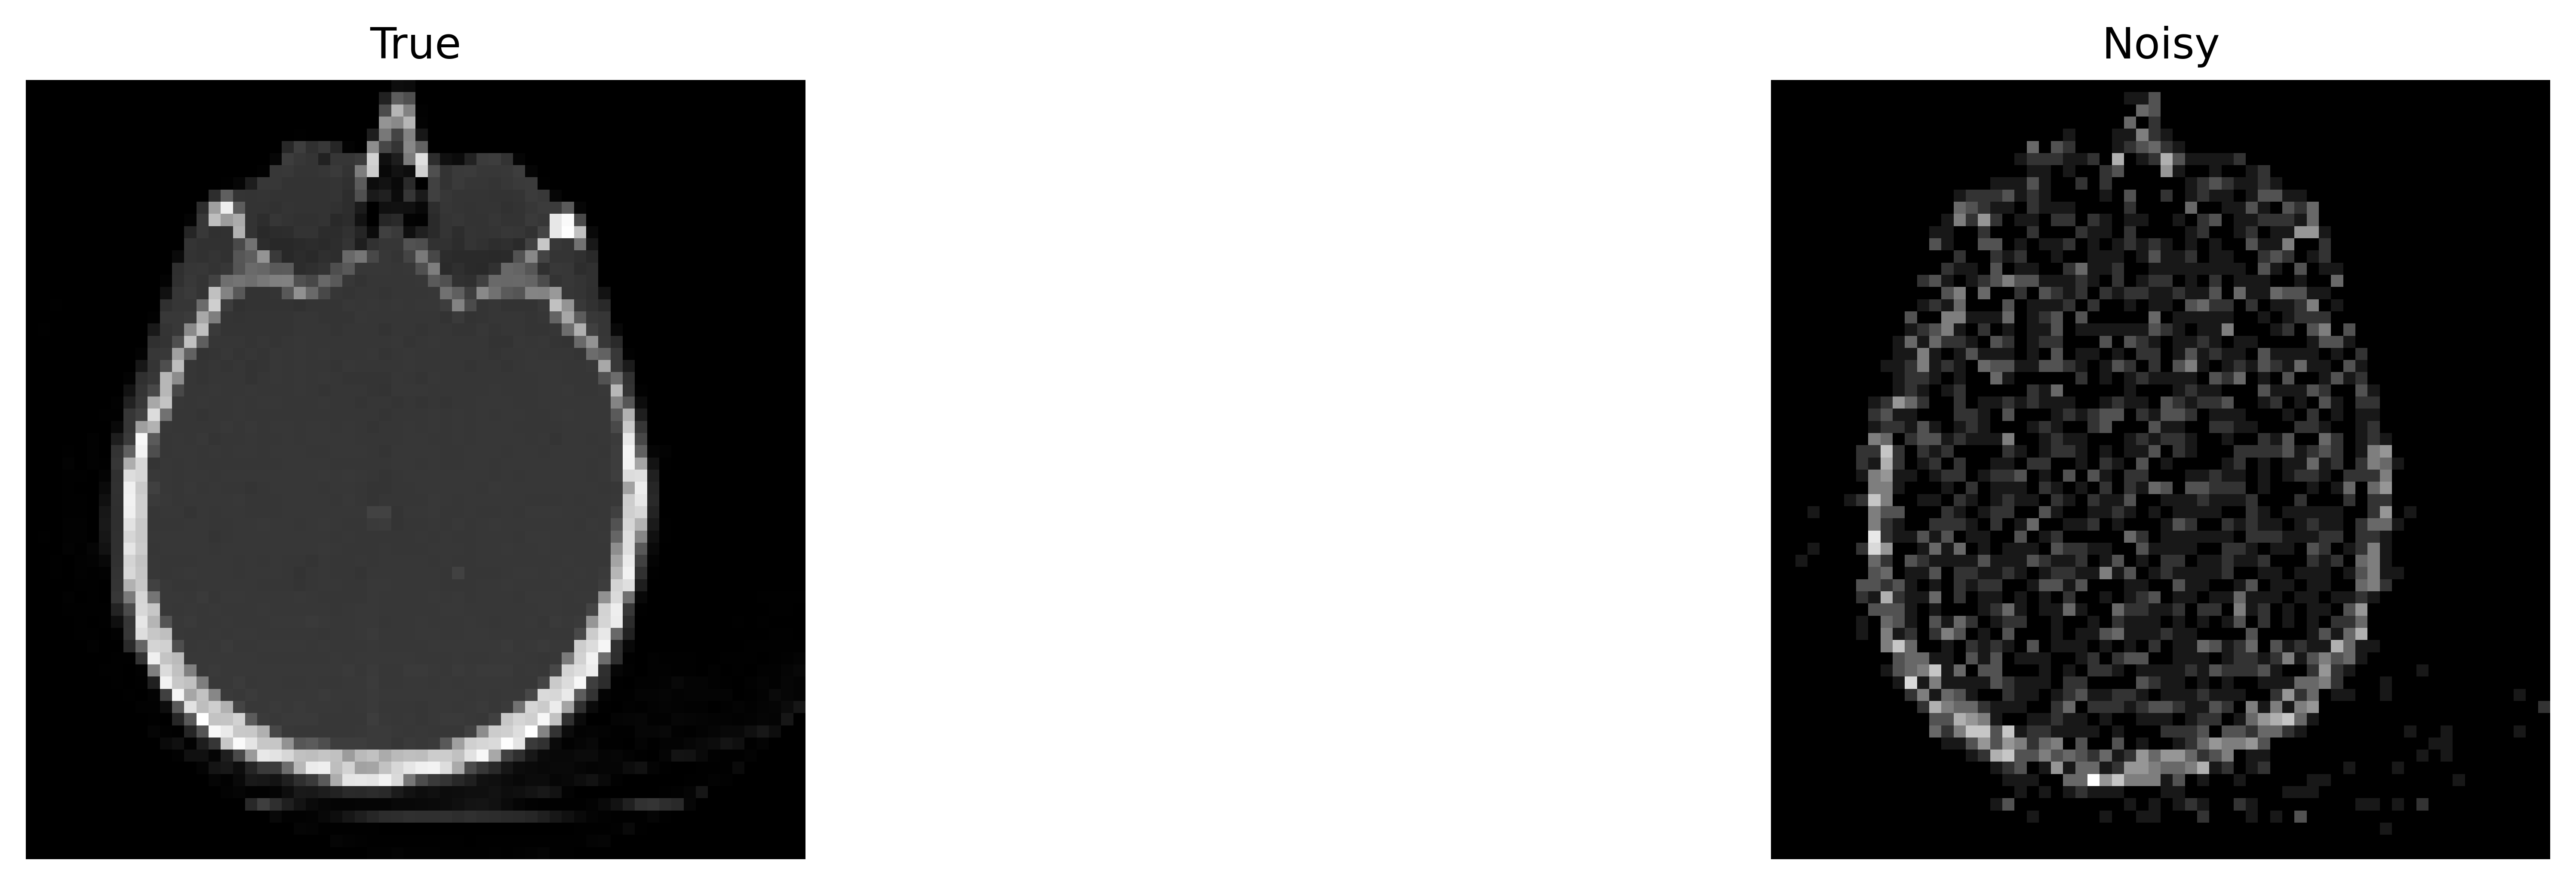

In [9]:
# MAKE NOISY IMAGE
brainimage           = brain();  activity_level = 10.0
true_object_np       = activity_level * resize(brainimage[5,30:-1,:-30], (nxd,nxd), anti_aliasing=False)
true_object_torch    = np_to_torch(true_object_np).to(device)
noisy_image_torch    = torch.poisson(true_object_torch)

fig1, axs1 = plt.subplots(1,2, figsize=(16,4)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(torch_to_np(true_object_torch), cmap='Greys_r'); axs1[0].set_title('True');  axs1[0].set_axis_off()
axs1[1].imshow(torch_to_np(noisy_image_torch), cmap='Greys_r'); axs1[1].set_title('Noisy'); axs1[1].set_axis_off()

In [10]:
#================================================================
# Now set up a CNN class 
#================================================================
class CNN(nn.Module):
    def __init__(self, num_channels):
        super(CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1,            num_channels, 3, padding=1, padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=1, padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=1, padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=1, padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, 1,            3, padding=1, padding_mode='reflect'), nn.PReLU()
        )
    def forward(self, x): return torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))

cnn = CNN(nxd).to(device)  # create a CNN object from the class 

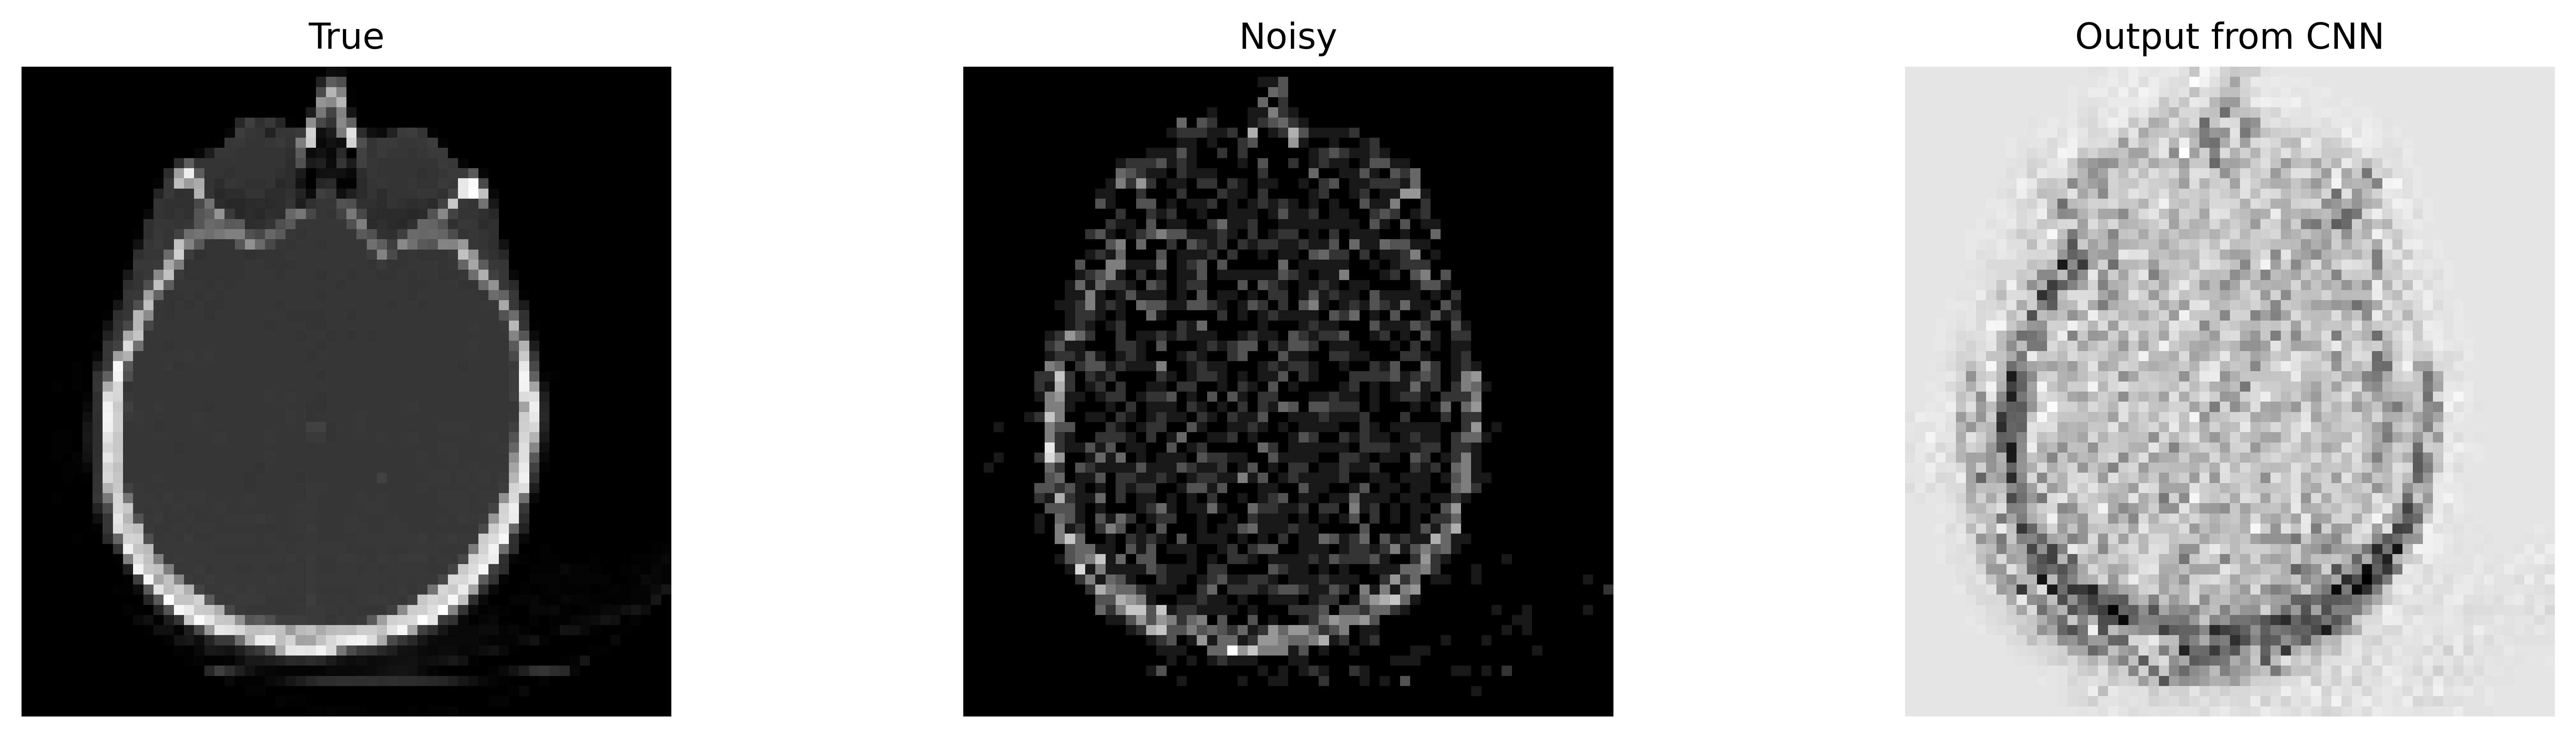

In [11]:
#Try out the CNN without any training
output_cnn = cnn(noisy_image_torch)

fig1, axs1 = plt.subplots(1,3, figsize=(16,4)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(torch_to_np(true_object_torch), cmap='Greys_r'); axs1[0].set_title('True'); axs1[0].set_axis_off()
axs1[1].imshow(torch_to_np(noisy_image_torch), cmap='Greys_r'); axs1[1].set_title('Noisy'); axs1[1].set_axis_off()
axs1[2].imshow(torch_to_np(output_cnn), cmap='Greys_r');        axs1[2].set_title('Output from CNN'); axs1[2].set_axis_off()

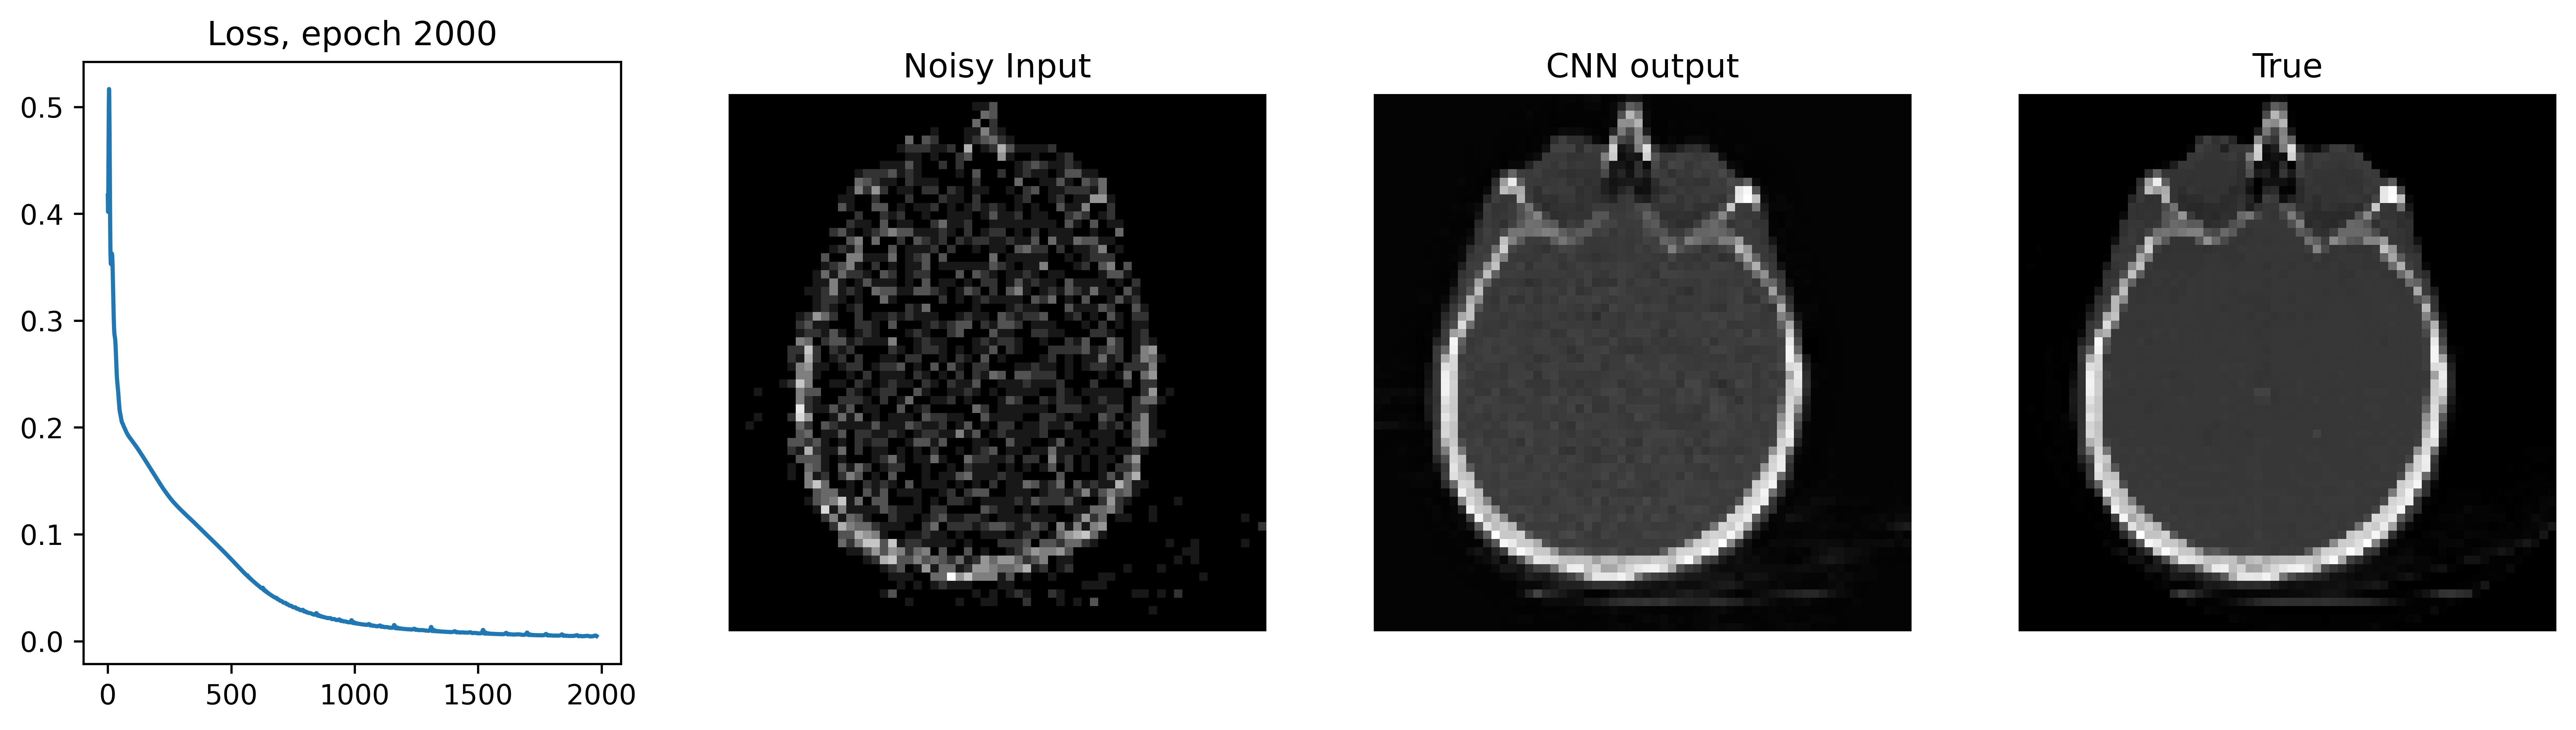

In [12]:
from IPython.display     import display, clear_output
#===============================================TRAIN THE CNN
loss_fun  = nn.MSELoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_loss = list()
epochs     = 2000

for ep in range(epochs+1):
    optimiser.zero_grad() # set the gradients to zero
    output_cnn = cnn(noisy_image_torch)

    loss = loss_fun(output_cnn, true_object_torch)
    
    train_loss.append(loss.item())
    loss.backward()    # Find the gradients
    optimiser.step()   # Does the update

    if ep % 50 == 0:
        fig2, ax = plt.subplots(1,4, figsize=(16,4)) 
        ax[0].plot(train_loss[19:-1]);                                ax[0].set_title('Loss, epoch %d' % ep)
        ax[1].imshow(torch_to_np(noisy_image_torch), cmap='Greys_r'); ax[1].set_title('Noisy Input')
        ax[2].imshow(torch_to_np(output_cnn),        cmap='Greys_r'); ax[2].set_title('CNN output')
        ax[3].imshow(torch_to_np(true_object_torch), cmap='Greys_r'); ax[3].set_title('True')
        ax[1].set_axis_off(); ax[2].set_axis_off();  ax[3].set_axis_off()
        if ep > epochs-1: plt.figure(1).savefig('CNN.svg', format='svg', dpi=1200)
        clear_output(wait=True); plt.pause(0.001)

In [13]:
#-------- Need to find out the number of projection bins in a parallel projection (a row of a sinogram)
empty_image   = np.zeros( (nxd,nxd) )
azi_angles    = np.linspace(0.0,180.0, nphi, endpoint=False)
sinogram_np   = radon(empty_image,azi_angles, circle=False)
nrd           = sinogram_np.shape[0]      # nrd is the no. of bins in a parallel projection

In [14]:
#---------------------------------TORCH SYSTEM MATRIX-------------------------------------------
def make_torch_system_matrix(nxd, nrd, nphi):
    point_source  = np.zeros( (nxd,nxd) )
    azi_angles    = np.linspace(0.0, 180.0,  nphi, endpoint=False)
    num_bins      = nrd * nphi
    num_pixels    = nxd * nxd
    system_matrix = torch.zeros(num_bins, num_pixels) # rows = num sino bins, cols = num image pixels
    col_index     = 0
    for xv in range(nxd):
        for yv in range(nxd):        # Now have selected pixel (xv, yv)
            point_source[:,:]   = 0.0
            point_source[xv,yv] = 1.0
            sinogram_np = radon(point_source,azi_angles, circle=False)
            system_matrix[:,col_index] = torch.reshape(np_to_torch(sinogram_np) ,(1, num_bins) )
            col_index += 1
    return system_matrix

def fp_system_torch(image, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat,   torch.reshape(image, (nxd*nxd,1))), (nrd, nphi))
def bp_system_torch(sino,  sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat.T, torch.reshape(sino, (nrd*nphi,1))), (nxd,nxd))

torch.Size([5824, 4096]) 64


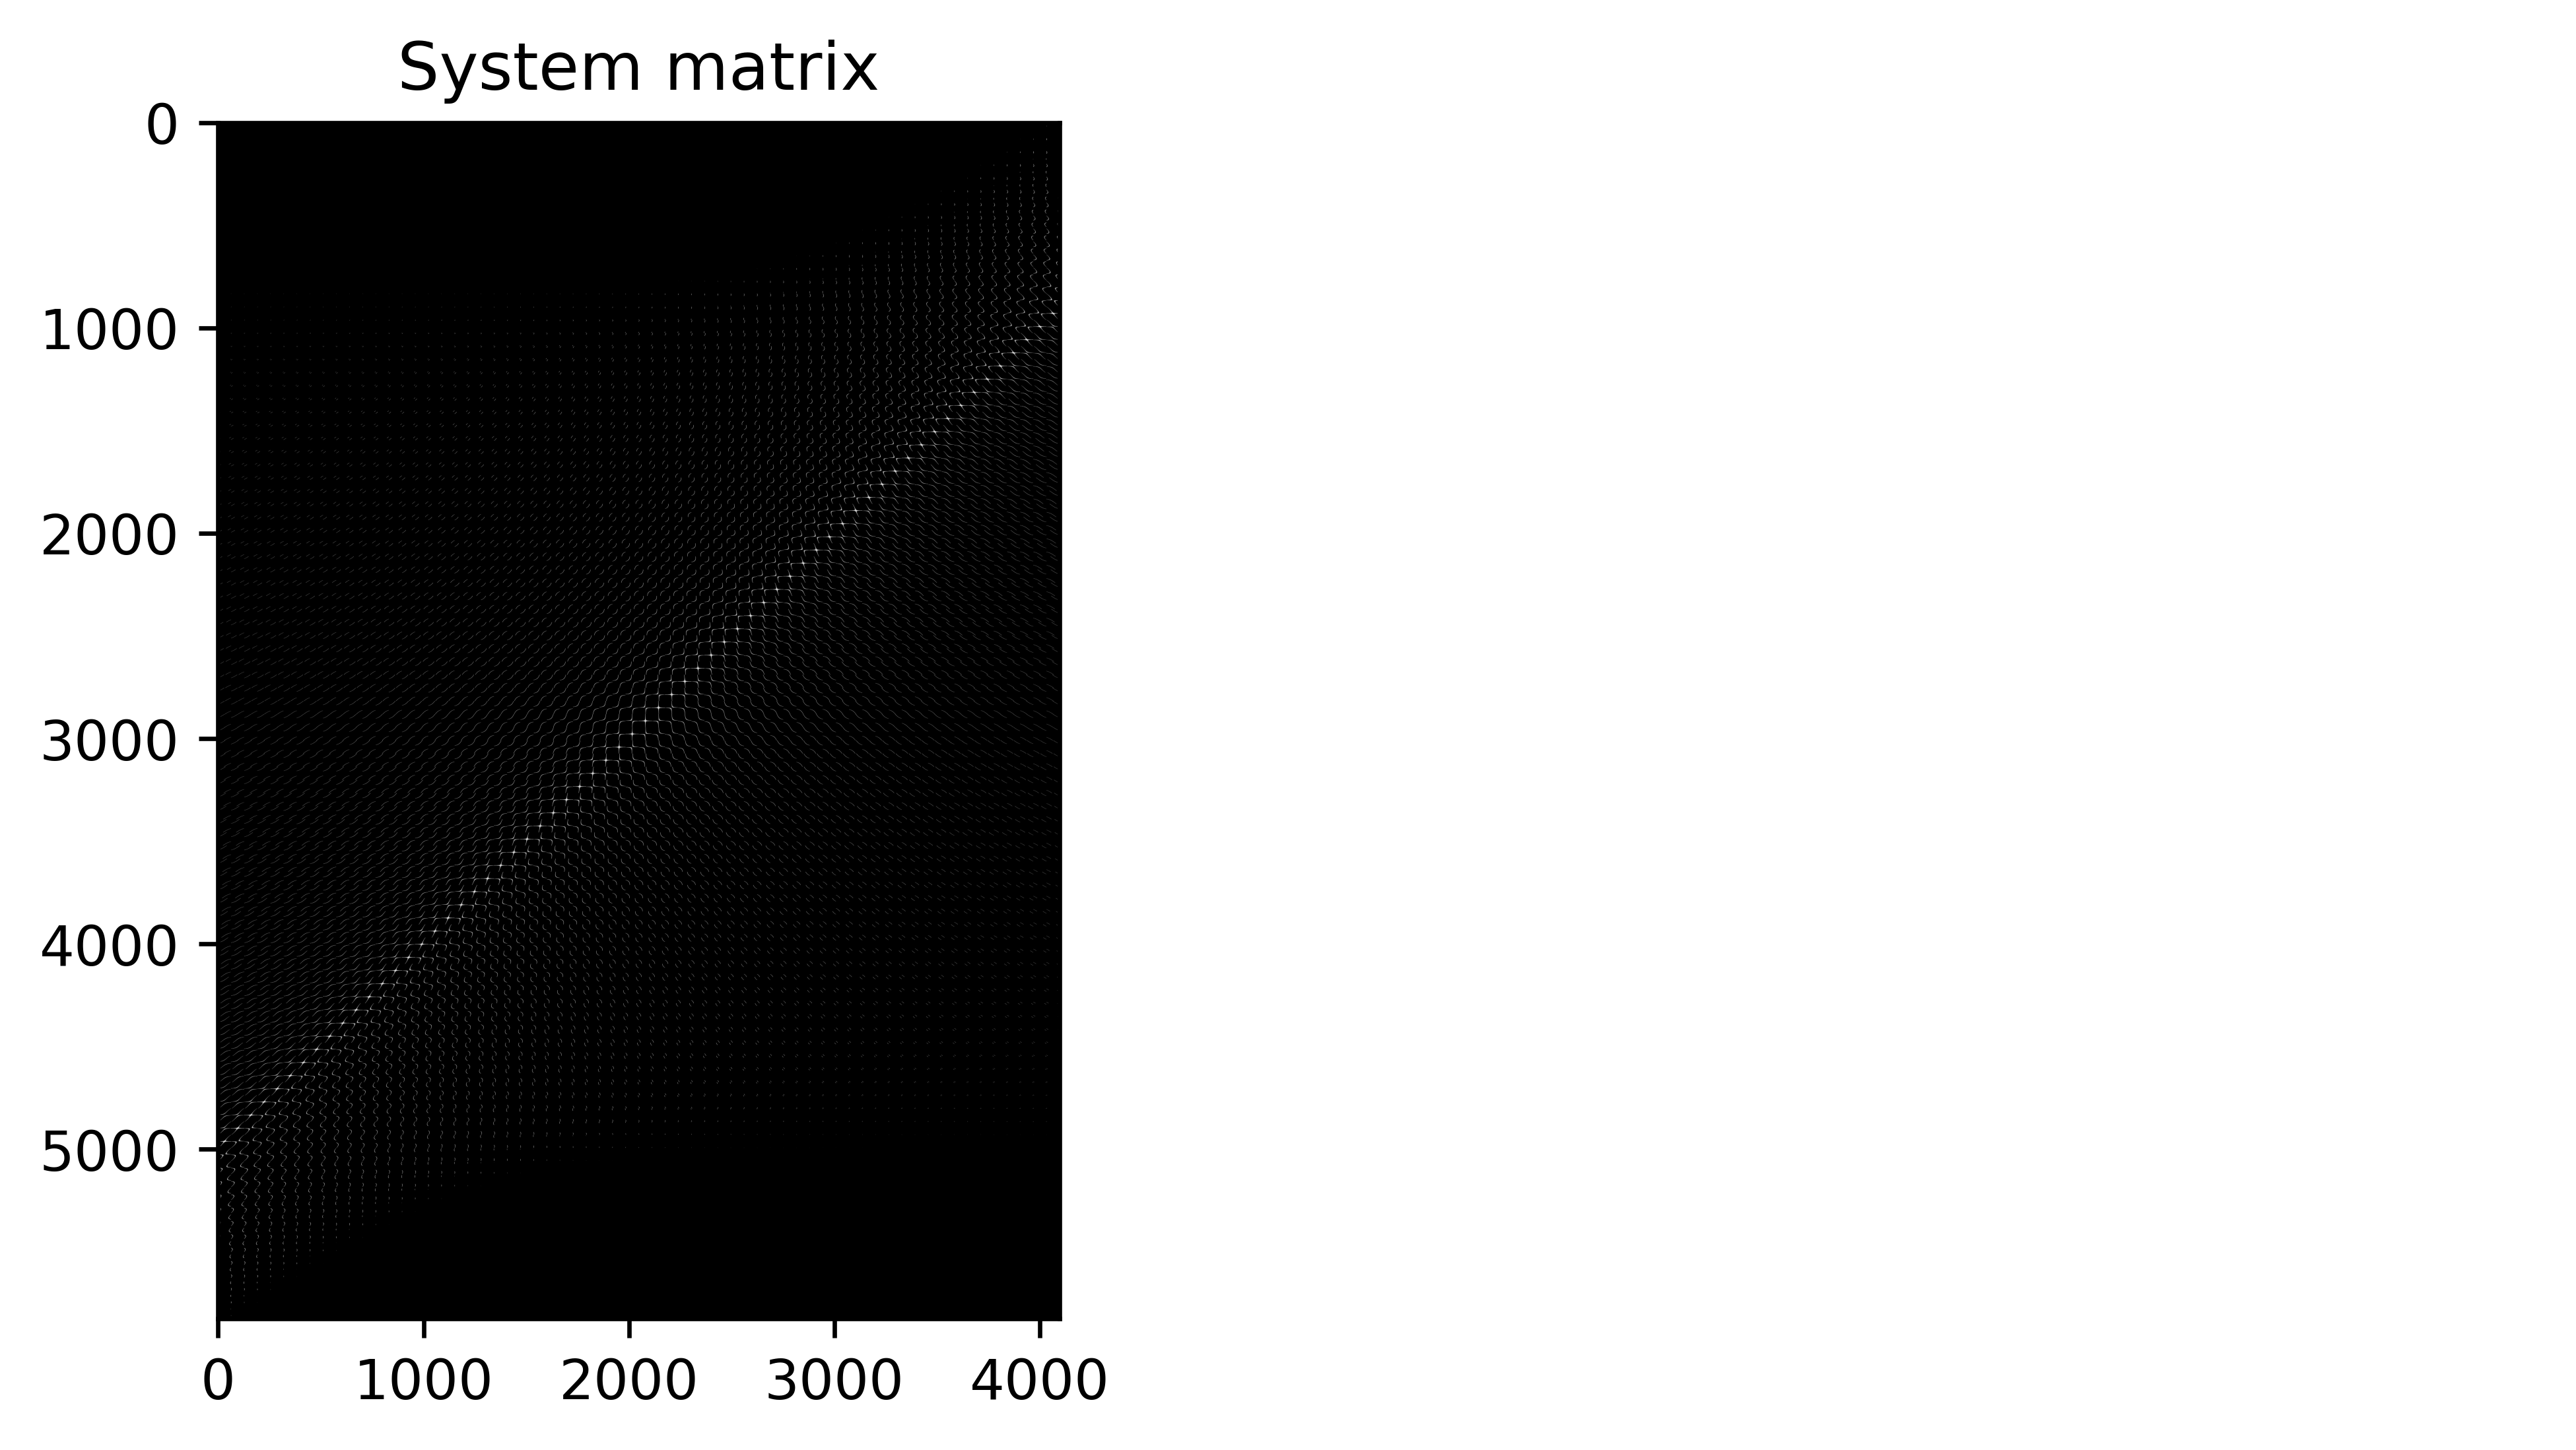

In [15]:
sys_mat    = make_torch_system_matrix(nxd, nrd, nphi).to(device);            print(sys_mat.shape, nxd)
fig1, axs1 = plt.subplots(1,2, figsize=(8,4)) 
axs1[0].imshow(torch_to_np(sys_mat), cmap='Greys_r'); axs1[0].set_title('System matrix'); axs1[1].set_axis_off(); 

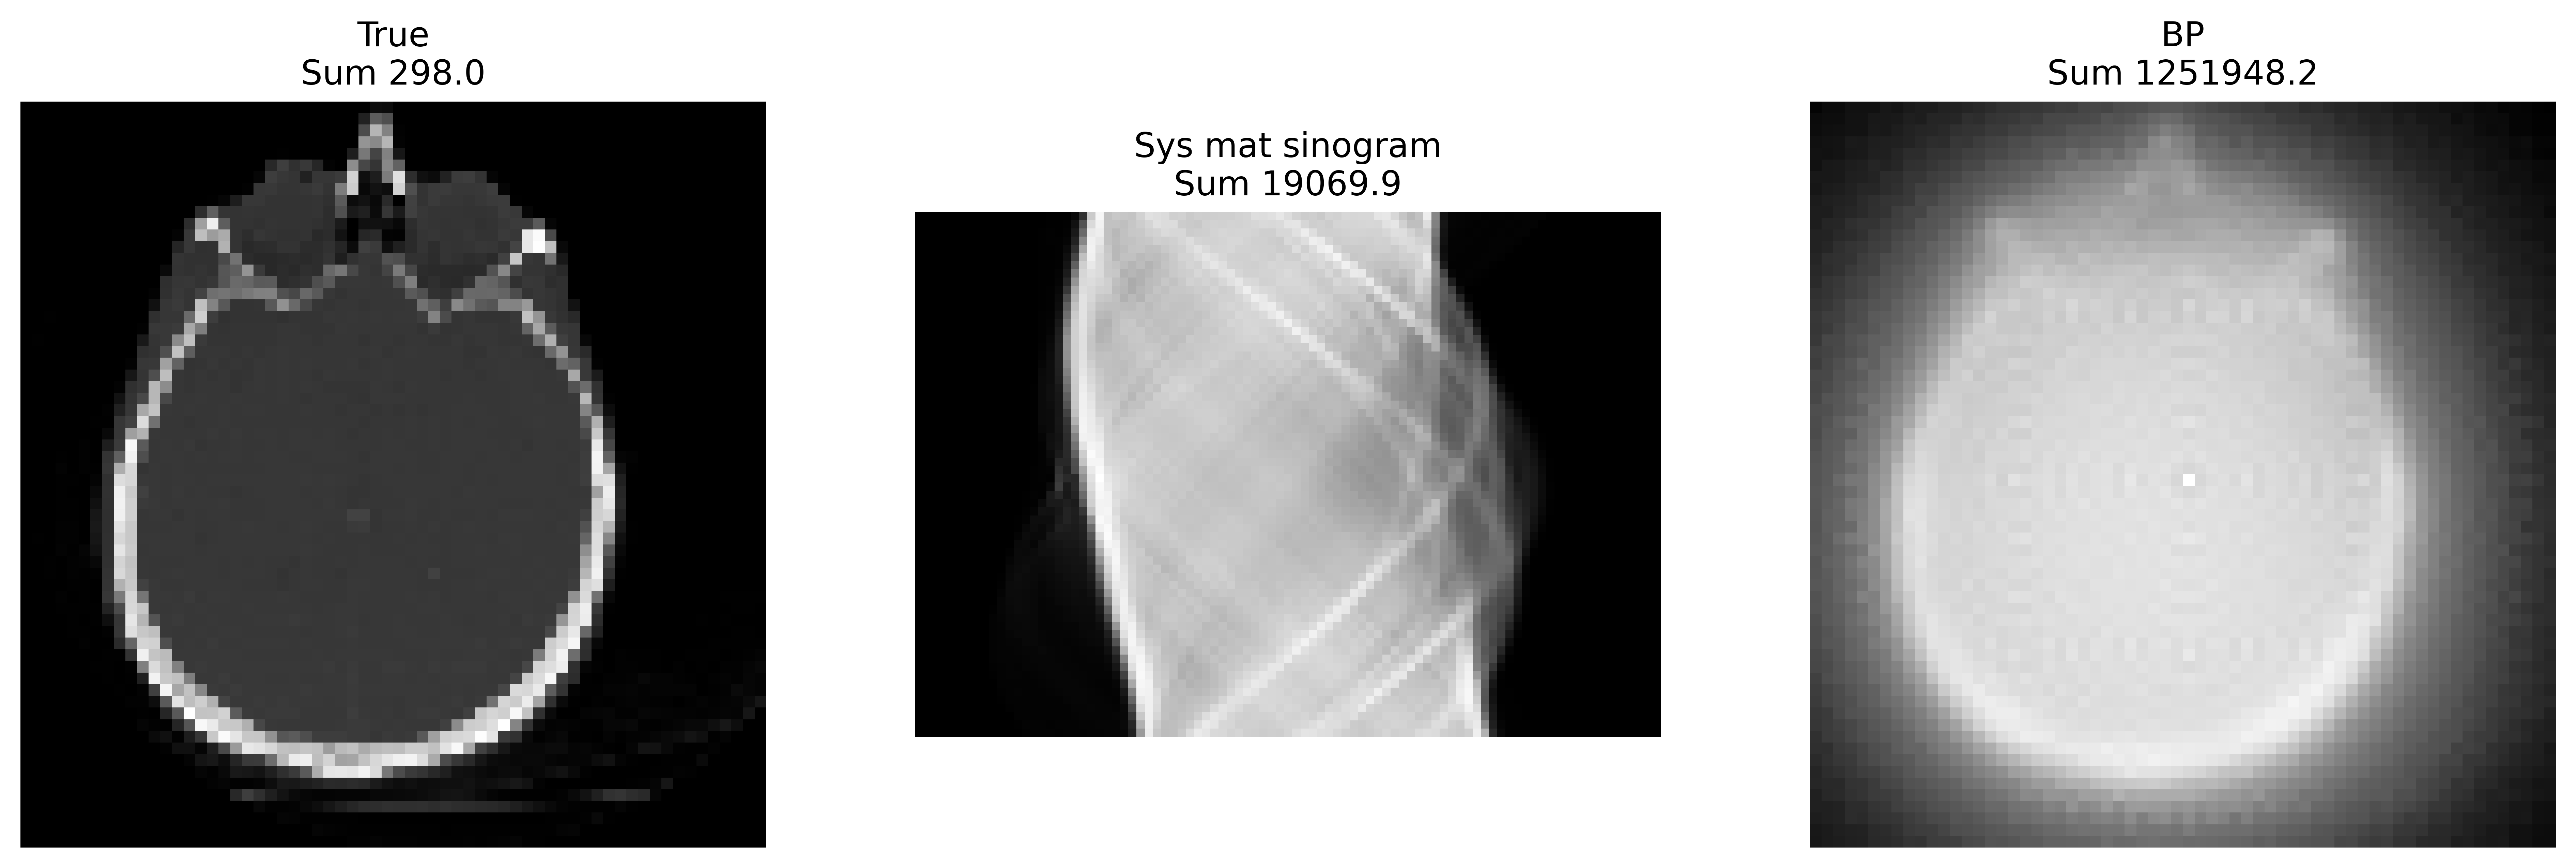

In [17]:
# TRY OUT THE SYSTEM MATRIX
brainimage       = brain()
true_object_np   = resize(brainimage[5,30:-1,:-30], (nxd,nxd), anti_aliasing=False)

fig1, axs1 = plt.subplots(1,3, figsize=(16,6)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(true_object_np, cmap='Greys_r');     axs1[0].set_title('True\nSum %.1f' % np.sum(true_object_np)); axs1[0].set_axis_off();

# Now do FP and BP via the torch system matrix
true_object_torch    = np_to_torch(true_object_np).to(device)
true_sinogram_torch  = fp_system_torch(true_object_torch, sys_mat, nxd, nrd, nphi)
bp_image_torch       = bp_system_torch(true_sinogram_torch, sys_mat, nxd, nrd, nphi) 

sinogram_from_sysmat_np   = torch_to_np(true_sinogram_torch)
bp_image_from_sysmat_np   = torch_to_np(bp_image_torch)

axs1[1].imshow(sinogram_from_sysmat_np.T, cmap='Greys_r'); axs1[1].set_title('Sys mat sinogram\nSum %.1f' % np.sum(sinogram_from_sysmat_np)); axs1[1].set_axis_off();
axs1[2].imshow(bp_image_from_sysmat_np,  cmap='Greys_r');  axs1[2].set_title('BP\nSum %.1f' % np.sum(bp_image_from_sysmat_np));   axs1[2].set_axis_off();

In [14]:
# Learned FBP
#================================================================
# Now create a recon network class: FBP with a CNN inter filter
#================================================================
class FBP_CNN_Net(nn.Module):
    def __init__(self, cnn, sino_for_reconstruction):
        super(FBP_CNN_Net, self).__init__()
        self.sino_ones  = torch.ones_like(sino_for_reconstruction)
        self.sens_image = bp_system_torch(self.sino_ones, sys_mat, nxd, nrd, nphi)
        self.cnn   = cnn
        self.prelu = nn.PReLU()
    def forward(self, sino_for_reconstruction):
        filtered_sino = self.cnn(sino_for_reconstruction)
        recon         = bp_system_torch(filtered_sino, sys_mat, nxd, nrd, nphi) / (self.sens_image+1.0e-15)
        recon         = self.prelu(recon)
        fpsino        = fp_system_torch(recon, sys_mat, nxd, nrd, nphi)
        return recon, fpsino, filtered_sino

cnn    = CNN(nxd).to(device)  # create a new CNN object from the CNN class 
fbpnet = FBP_CNN_Net(cnn, true_sinogram_torch).to(device)

Text(0.5, 1.0, 'FP recon')

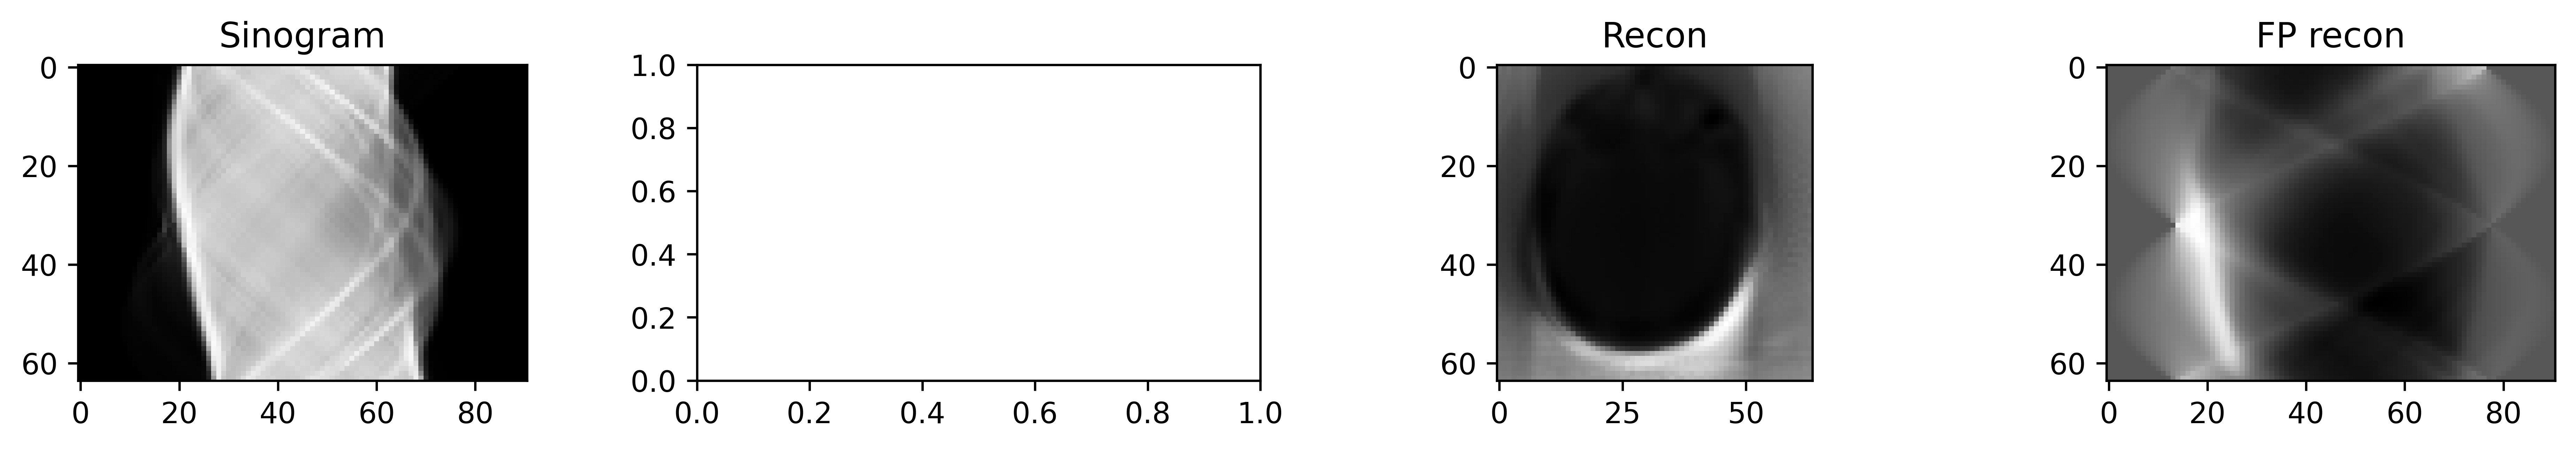

In [15]:
#Try the reconstruction without any training
recon, rec_fp, filtered_sino = fbpnet(true_sinogram_torch)
fig2, axs2 = plt.subplots(1,4, figsize=(16,2)) # No. rows, cols,  figsize Width,Height (inches)
axs2[0].imshow(torch_to_np(true_sinogram_torch).T, cmap='Greys_r'); axs2[0].set_title('Sinogram')
axs2[2].imshow(torch_to_np(recon), cmap='Greys_r');                 axs2[2].set_title('Recon')
axs2[3].imshow(torch_to_np(rec_fp).T, cmap='Greys_r');              axs2[3].set_title('FP recon')

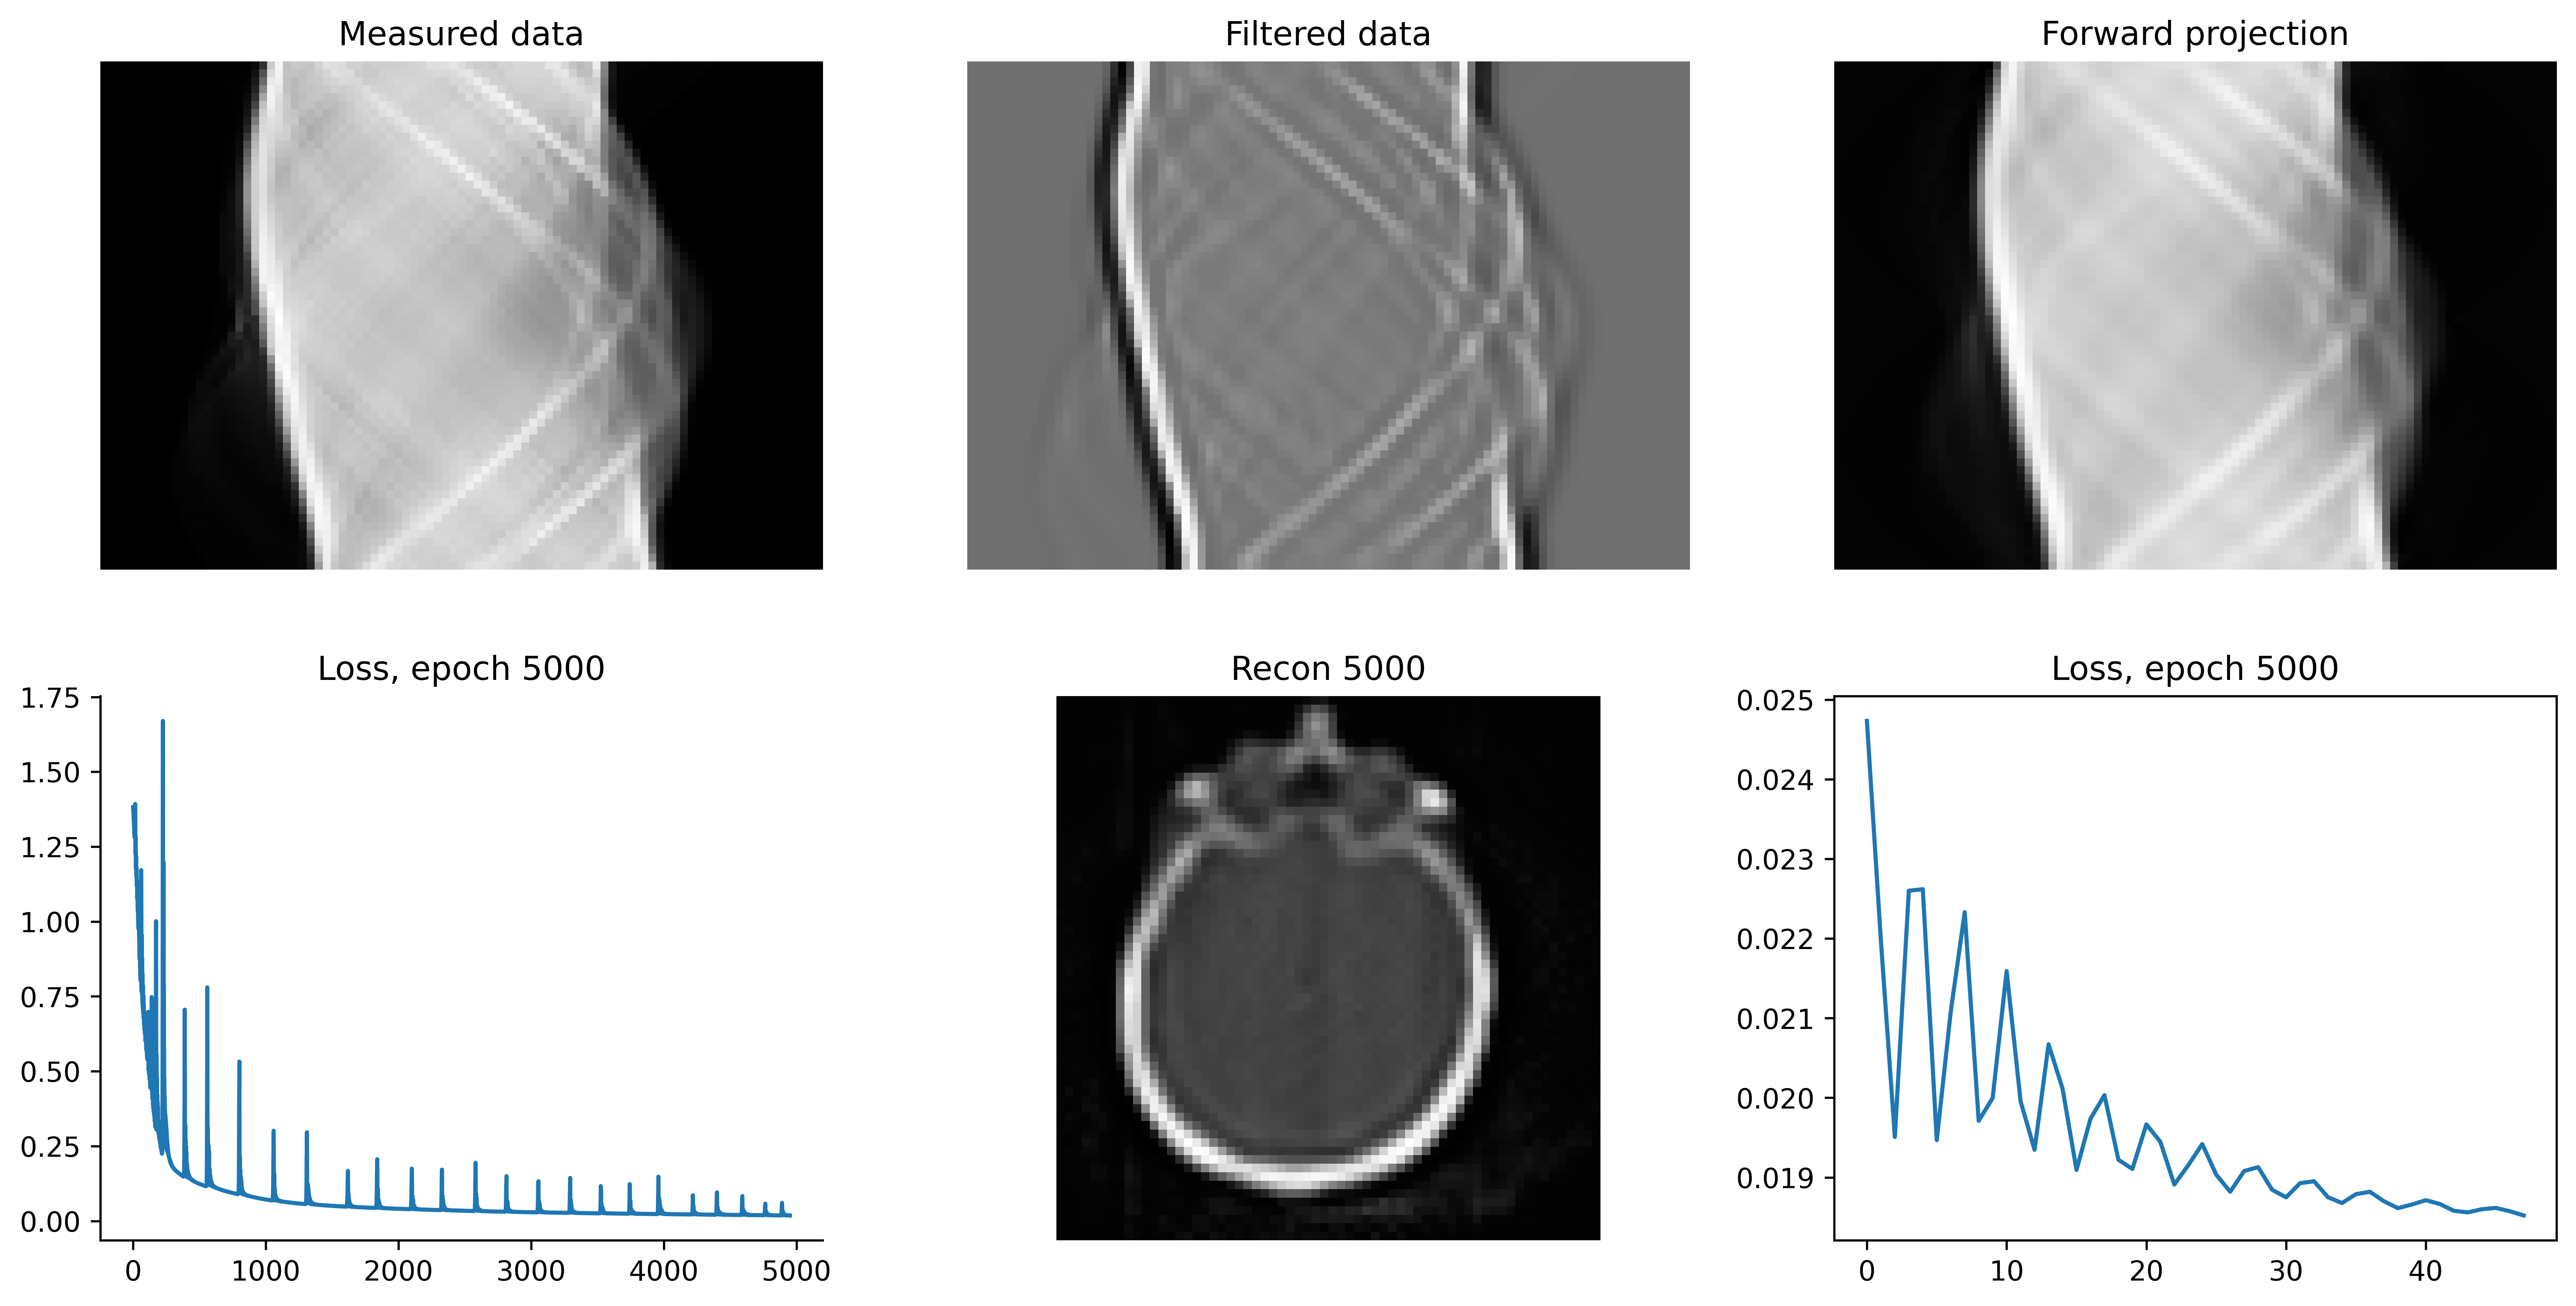

In [15]:
#===============================================TRAIN THE fbpnet NETWORK
loss_fun  = nn.MSELoss()
optimiser = torch.optim.Adam(fbpnet.parameters(), lr=1e-4)
train_loss = list()

for ep in range(5000 +1):
    optimiser.zero_grad() # set the gradients to zero
    recon, rec_fp, filtered_sino = fbpnet(true_sinogram_torch)
    # Self-supervised, data fidelity
    loss = loss_fun(rec_fp, torch.squeeze(true_sinogram_torch))
    # Ground truth supervised -> #loss = loss_fun(recon, torch.squeeze(true_object_torch))
    train_loss.append(loss.item())
    loss.backward()   # Find the gradients
    optimiser.step()  # Does the update

    if ep % 50 == 0:
        fig2, axs2 = plt.subplots(2,3, figsize=(16,8)) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].imshow(torch_to_np(true_sinogram_torch).T, cmap='Greys_r'); axs2[0,0].set_title('Measured data')
        axs2[0,1].imshow(torch_to_np(filtered_sino).T, cmap='Greys_r');       axs2[0,1].set_title('Filtered data')
        axs2[0,0].set_axis_off(); axs2[0,1].set_axis_off() 
        axs2[0,2].set_axis_off(); axs2[1,1].set_axis_off()
        axs2[1,1].imshow(torch_to_np(recon), cmap='Greys_r'); axs2[1,1].set_title('Recon %d' % (ep))
      
        axs2[0,2].imshow(torch_to_np(rec_fp).T, cmap='Greys_r'); axs2[0,2].set_title('Forward projection')
        axs2[1,2].plot(train_loss[-49:-1]);  axs2[1,2].set_title('Loss, epoch %d' % ep) 
        axs2[1,0].plot(train_loss[49:-1]);   axs2[1,0].set_title('Loss, epoch %d' % ep)   
        axs2[1,0].spines['top'].set_visible(False); axs2[1,0].spines['right'].set_visible(False)
        clear_output(wait=True); plt.pause(0.001)

In [16]:
#================================================================
# Now create a recon network class: process z with a CNN 
#================================================================
class Z_CNN_Net(nn.Module):
    def __init__(self, cnn, nxd, input_image):
        super(Z_CNN_Net, self).__init__()
        self.z_image    = input_image
        self.cnn        = cnn
    def forward(self):
        recon         = self.cnn(self.z_image)
        fpsino        = fp_system_torch(recon, sys_mat, nxd, nrd, nphi)
        return recon, fpsino

z_image    = torch.rand(nxd,nxd).to(device)
cnn        = CNN(nxd).to(device)  # create a new CNN object from the CNN class 
znet       = Z_CNN_Net(cnn, nxd, z_image).to(device)

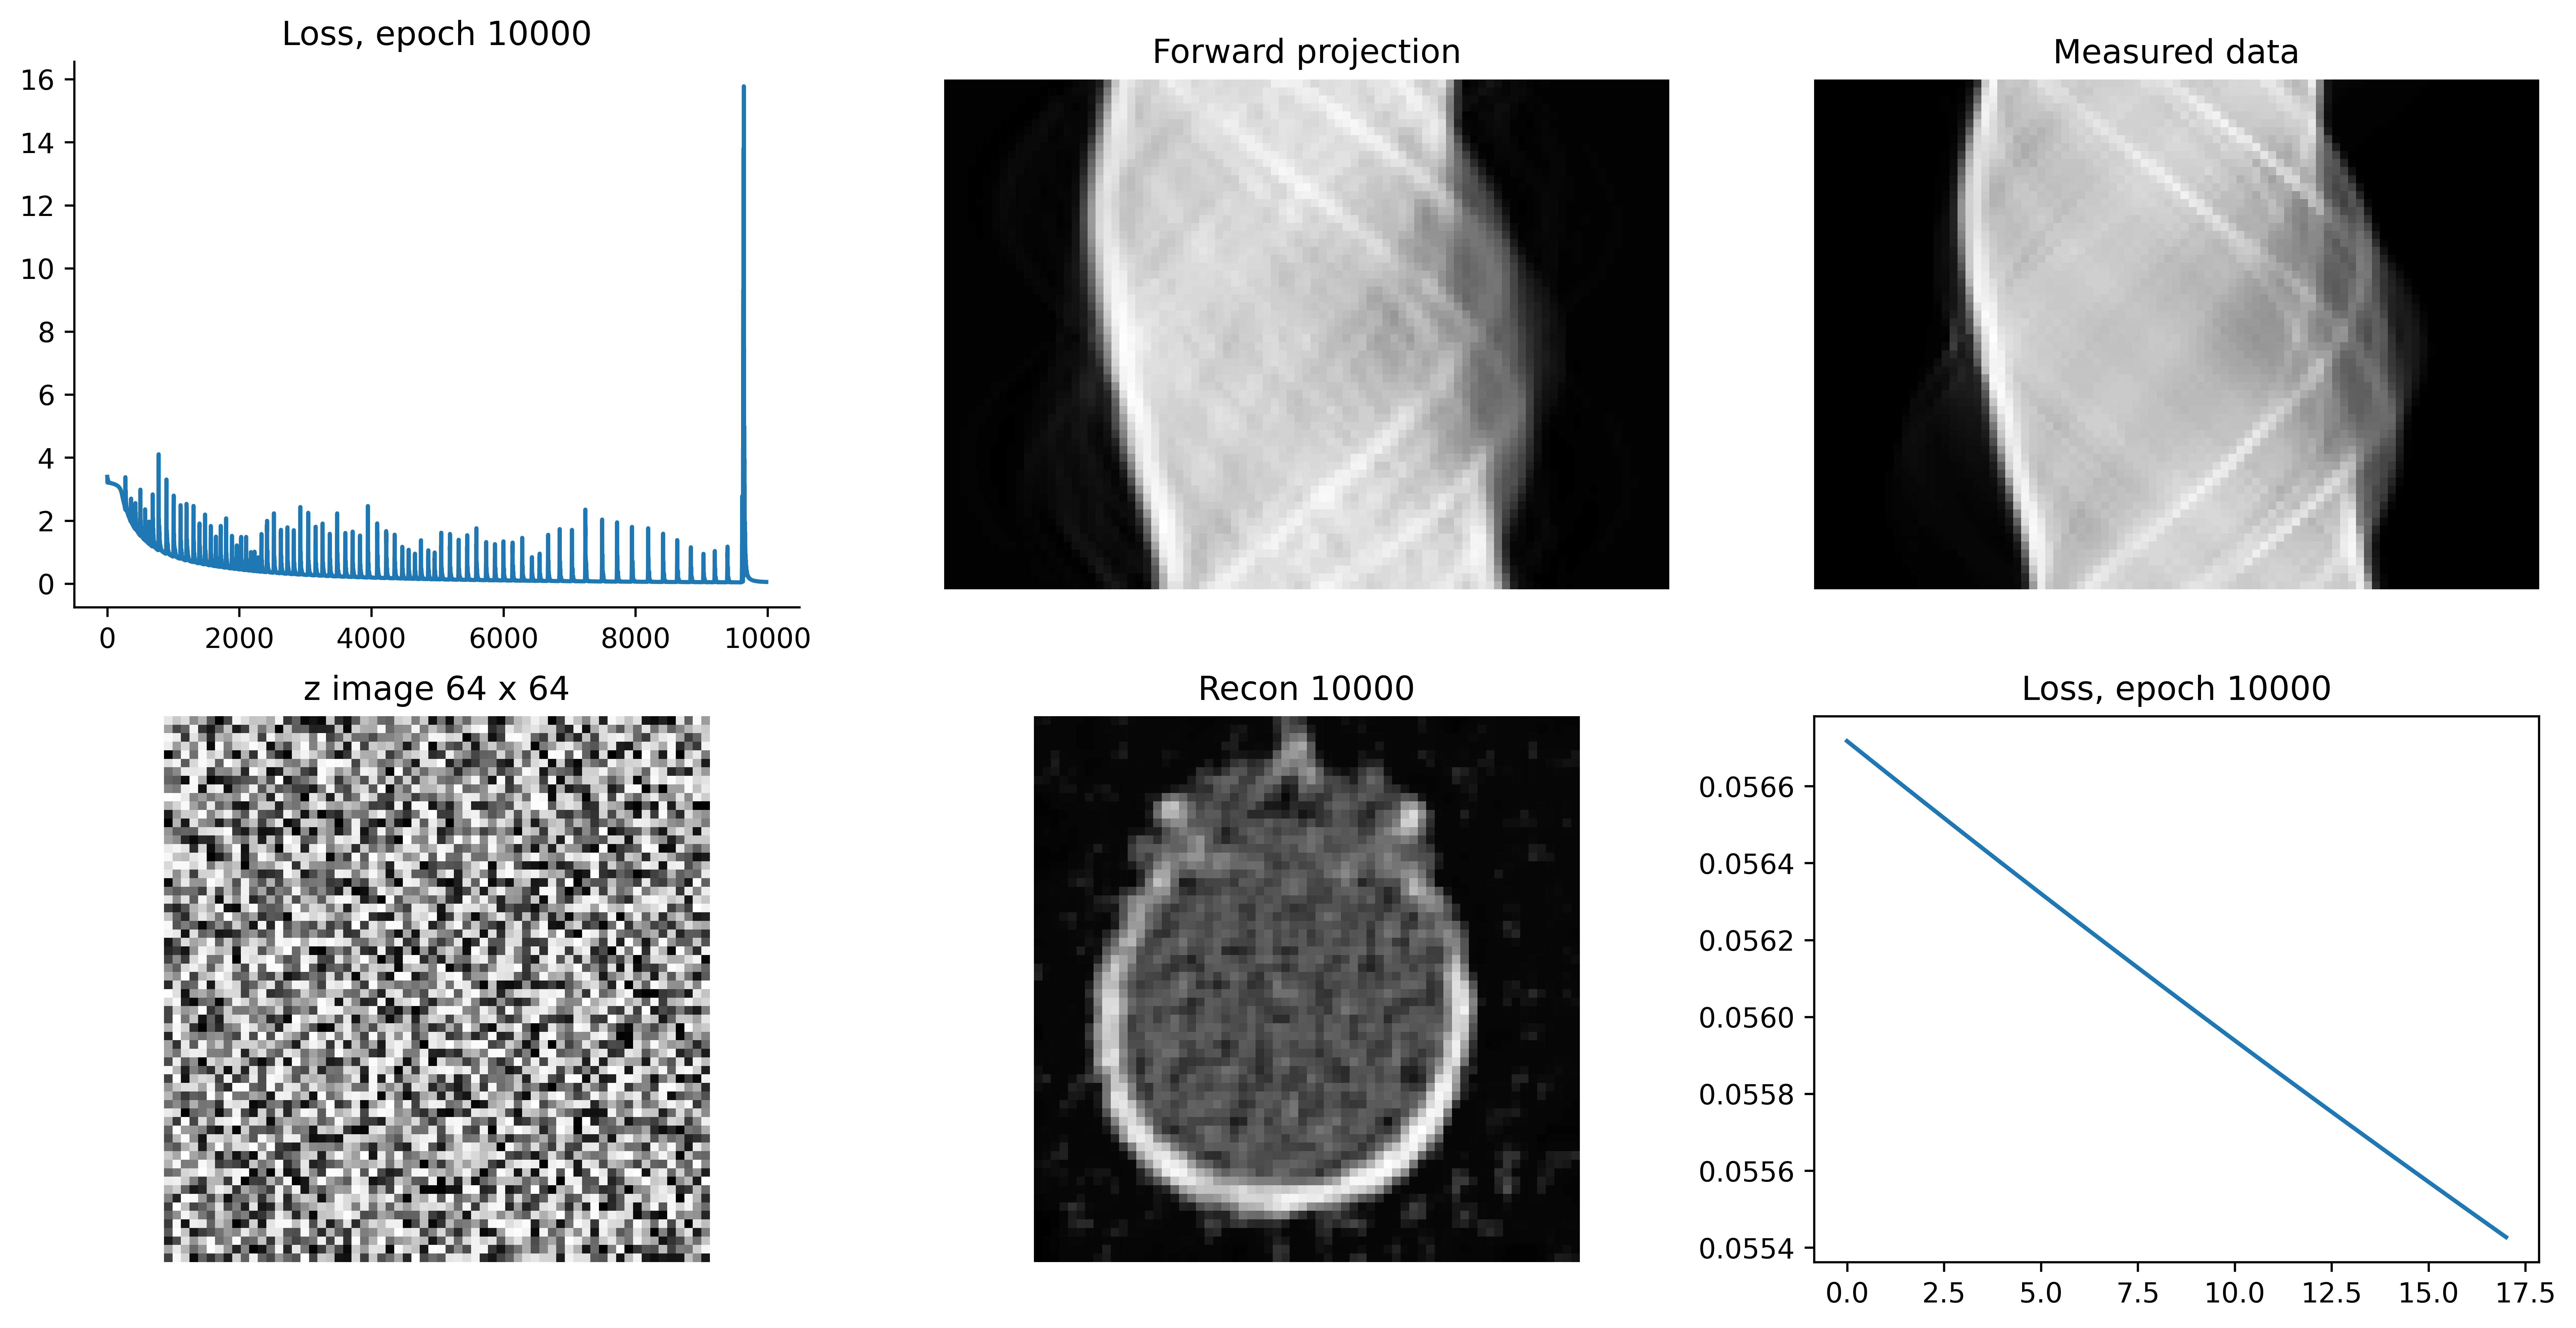

In [17]:
#===============================================TRAIN THE NETWORK
loss_fun  = nn.MSELoss()
optimiser = torch.optim.Adam(znet.parameters(), lr=1e-4)
train_loss = list()

for ep in range(10000 +1):
    optimiser.zero_grad() # set the gradients to zero
    recon, rec_fp    = znet()
    loss = loss_fun(rec_fp, torch.squeeze(true_sinogram_torch))
    train_loss.append(loss.item())
    loss.backward() # Find the gradients
    optimiser.step() # Does the update

    if ep % 50 == 0:
        fig2, axs2 = plt.subplots(2,3, figsize=(16,8)) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].spines['top'].set_visible(False); axs2[0,0].spines['right'].set_visible(False)
        axs2[0,1].set_axis_off(); axs2[0,2].set_axis_off(); 
        axs2[1,0].set_axis_off(); axs2[1,1].set_axis_off(); 
        axs2[0,2].imshow(torch_to_np(true_sinogram_torch).T, cmap='Greys_r'); axs2[0,2].set_title('Measured data')
        axs2[0,1].imshow(torch_to_np(rec_fp).T, cmap='Greys_r'); axs2[0,1].set_title('Forward projection')
        axs2[1,0].imshow(torch_to_np(z_image), cmap='Greys_r'); axs2[1,0].set_title('z image %d x %d' % (nxd,nxd))
        axs2[1,1].imshow(torch_to_np(recon), cmap='Greys_r'); axs2[1,1].set_title('Recon %d' % (ep))
        axs2[1,2].plot(train_loss[-19:-1]);  axs2[1,2].set_title('Loss, epoch %d' % ep);   
        axs2[0,0].plot(train_loss[19:-1]);  axs2[0,0].set_title('Loss, epoch %d' % ep);   
        clear_output(wait=True); plt.pause(0.001)

In [18]:
#================================================================
# Now create a recon network class: MLEM
#================================================================
class MLEM_Net(nn.Module):
    def __init__(self, num_iterations, cnn, sino_for_reconstruction):
        super(MLEM_Net, self).__init__()
        self.num_iterations = num_iterations
        self.sino_ones  = torch.ones_like(sino_for_reconstruction)
        self.sens_image = bp_system_torch(self.sino_ones, sys_mat, nxd, nrd, nphi)
        self.cnn   = cnn
        self.prelu = nn.PReLU()
    def forward(self, sino_for_reconstruction):
        recon_image = torch.ones(nxd,nxd).to(device)
        for it in range(self.num_iterations):
            fpsino        = fp_system_torch(recon_image, sys_mat, nxd, nrd, nphi)
            ratio_sino    = sino_for_reconstruction / (fpsino + 1e-10)
            bp_ratio_sino = bp_system_torch(ratio_sino, sys_mat, nxd, nrd, nphi) 
            recon_image   = recon_image * bp_ratio_sino / (self.sens_image + 1e-10)
            # Inter update regularisation
            recon_image   = torch.abs(self.cnn(recon_image))
        return recon_image, fpsino, ratio_sino, bp_ratio_sino

number_MLEM_iterations = 2
sinogram_to_use_torch = true_sinogram_torch
# instantiate the class - create an object
mlemnet = MLEM_Net(number_MLEM_iterations, cnn, sinogram_to_use_torch).to(device)

Text(0.5, 1.0, 'Measured')

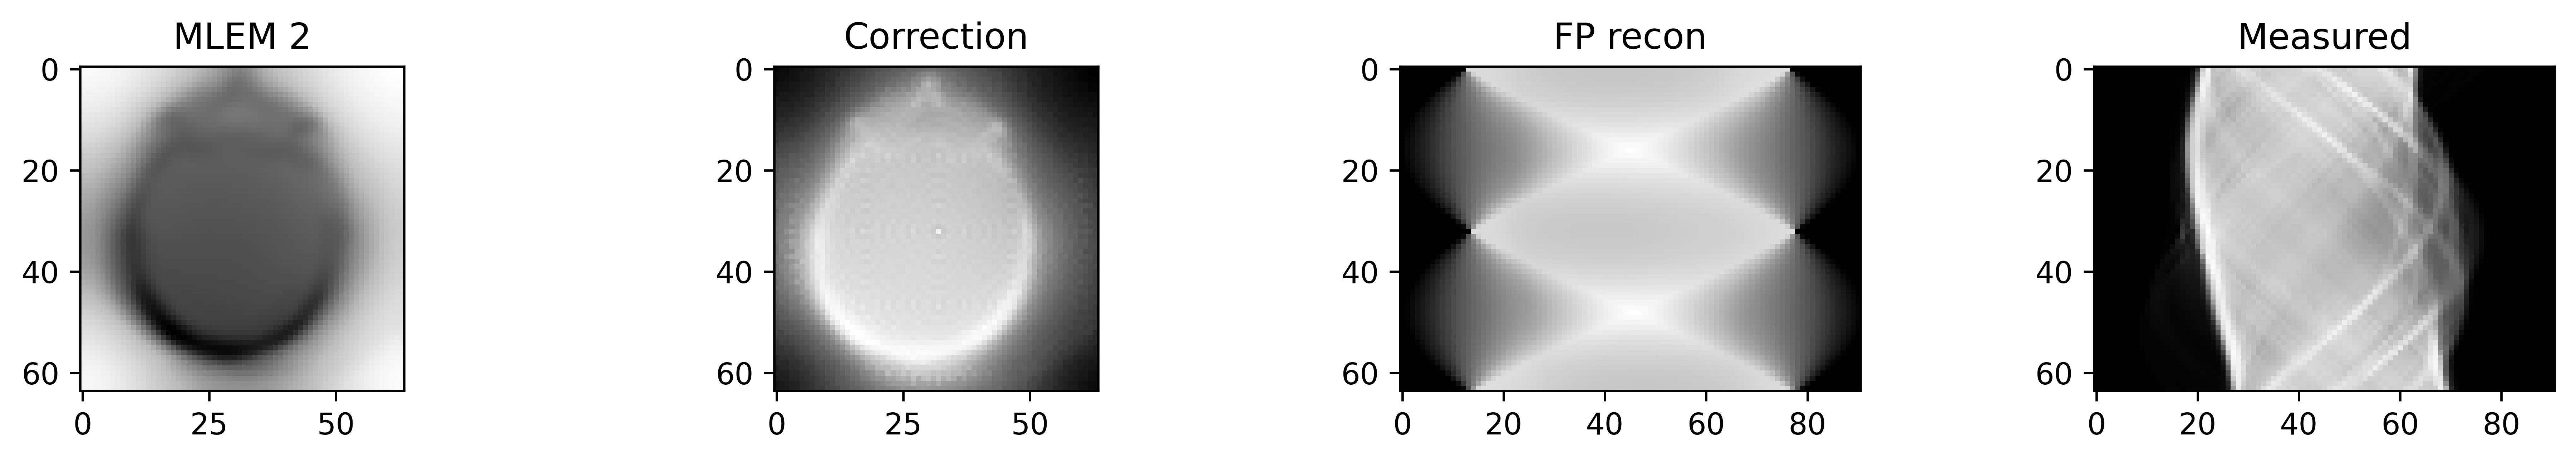

In [19]:
#Try the reconstruction without any training
recon, rec_fp, ratio_sino, bp_ratio_sino = mlemnet(sinogram_to_use_torch)
fig2, axs2 = plt.subplots(1,4, figsize=(16,2))  
axs2[0].imshow(torch_to_np(recon), cmap='Greys_r');                 axs2[0].set_title('MLEM %d' % (number_MLEM_iterations))
axs2[1].imshow(torch_to_np(bp_ratio_sino), cmap='Greys_r');         axs2[1].set_title('Correction')
axs2[2].imshow(torch_to_np(rec_fp).T, cmap='Greys_r');              axs2[2].set_title('FP recon')
axs2[3].imshow(torch_to_np(true_sinogram_torch).T, cmap='Greys_r'); axs2[3].set_title('Measured')

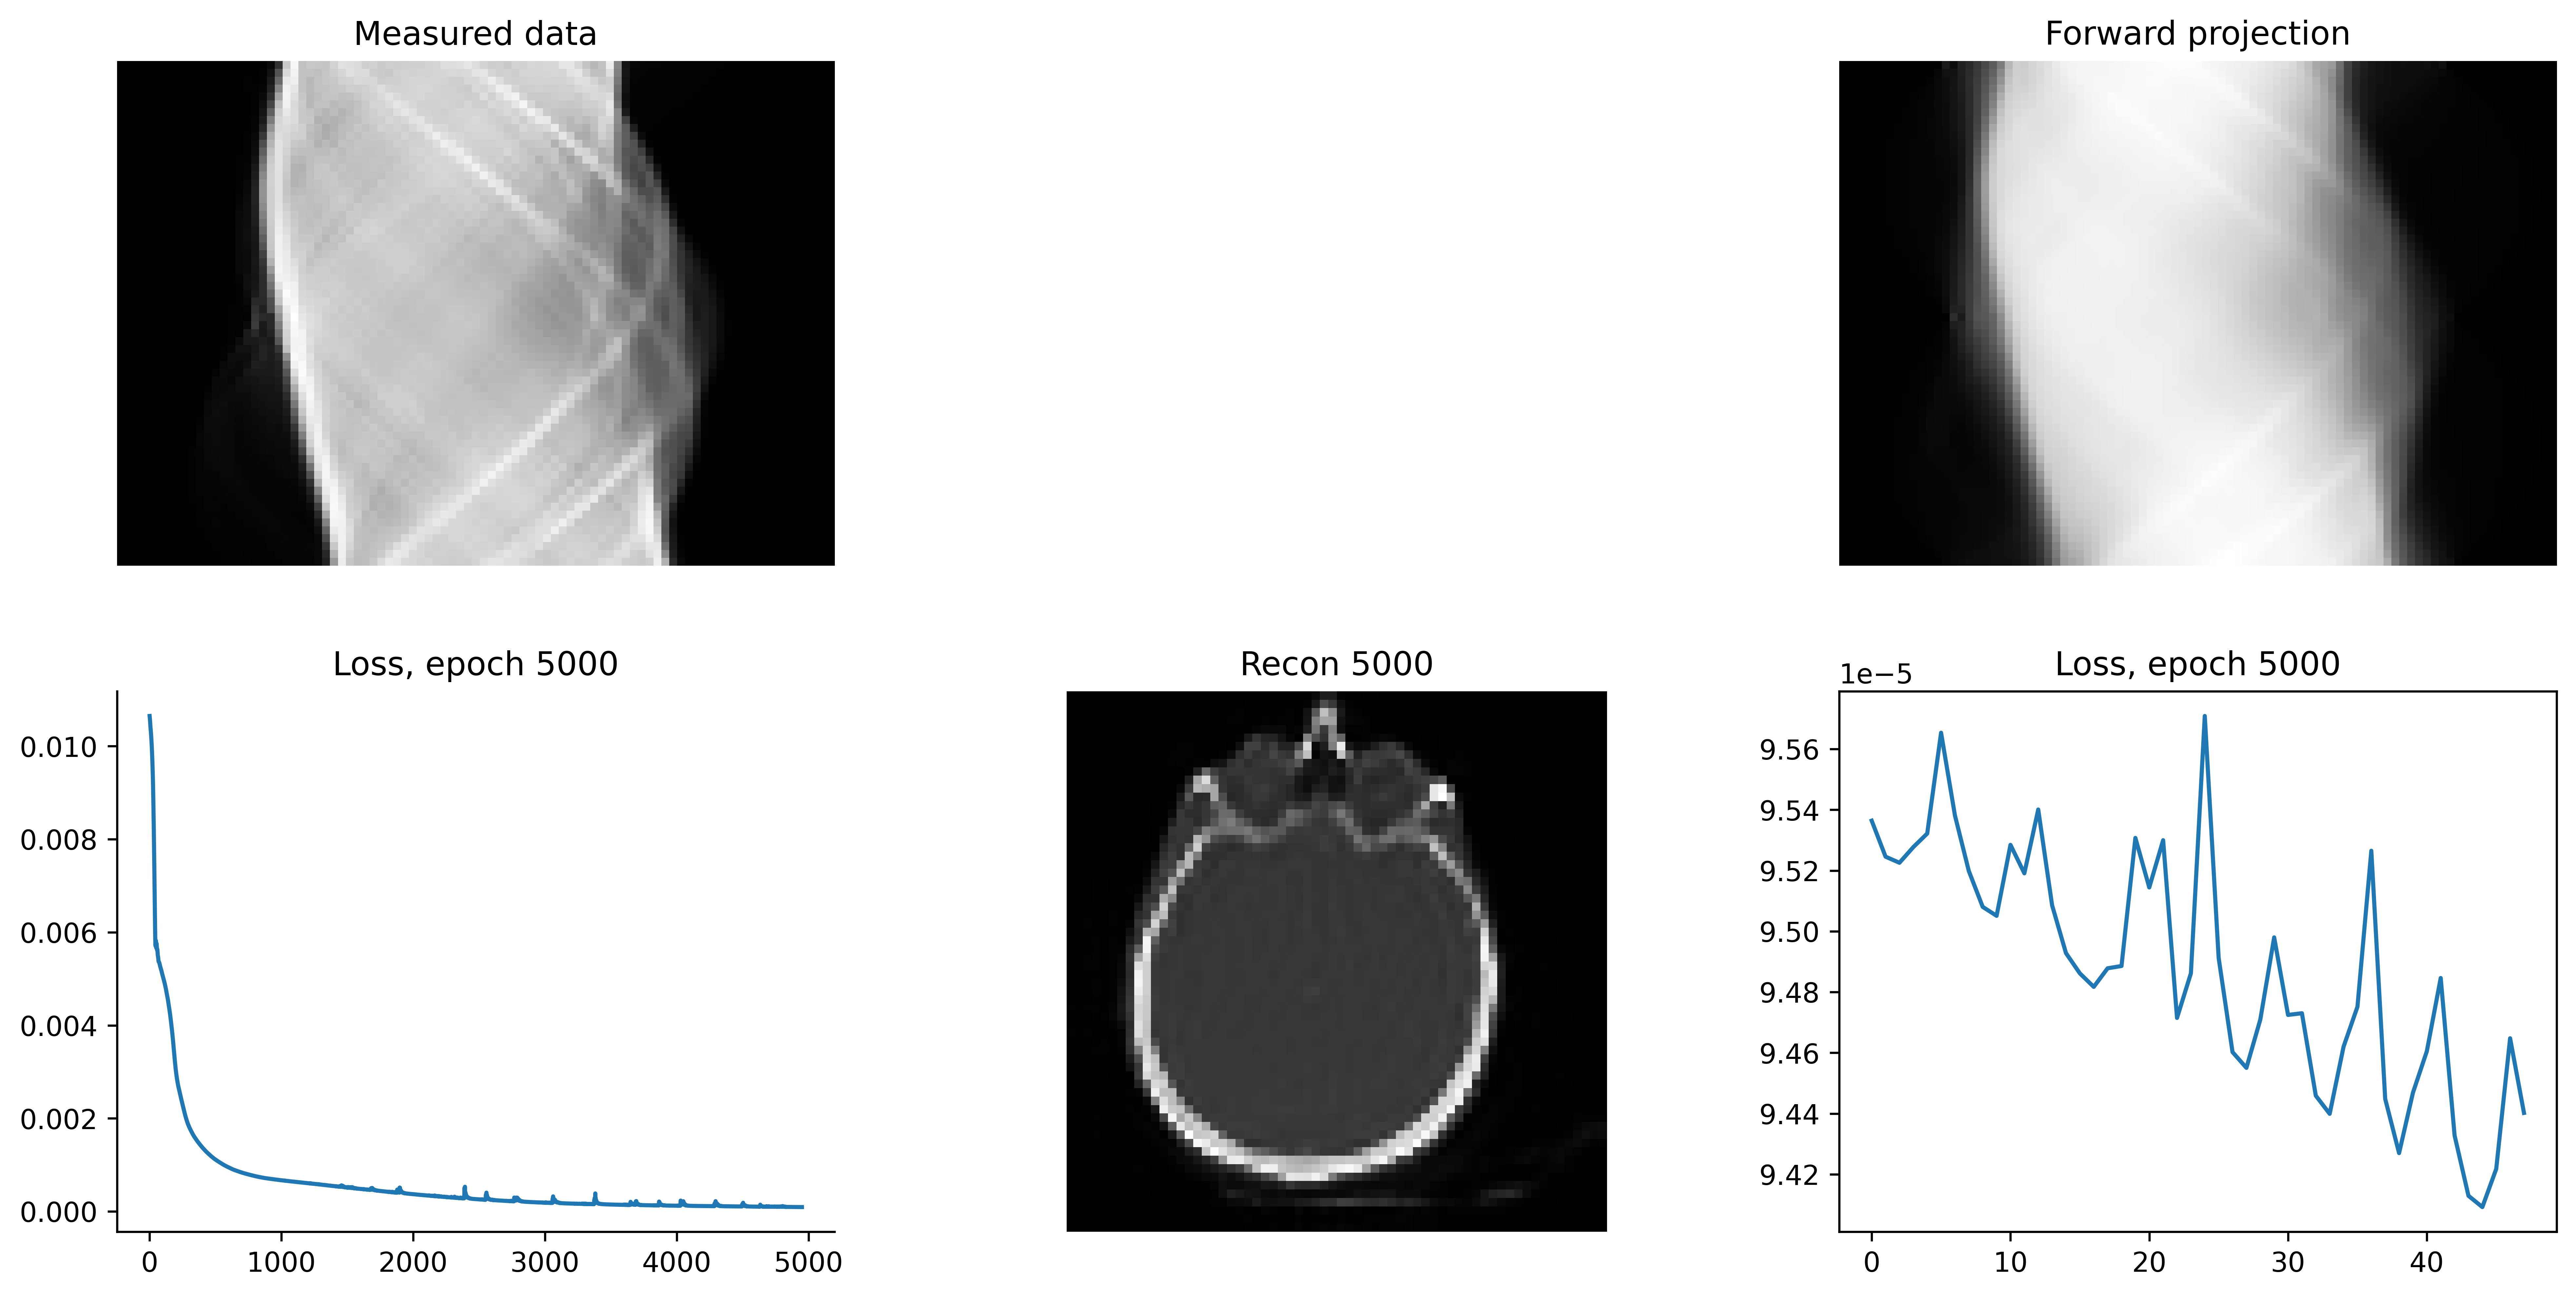

In [20]:
#===============================================TRAIN THE NETWORK
loss_fun  = nn.MSELoss()
optimiser = torch.optim.Adam(mlemnet.parameters(), lr=1e-4)

train_loss = list()

for ep in range(5000+1):
    optimiser.zero_grad() # set the gradients to zero
    recon, rec_fp, ratio_sino, bp_ratio_sino = mlemnet(sinogram_to_use_torch)
    
    # Ground truth supervised
    loss = loss_fun(recon, torch.squeeze(true_object_torch))
    
    train_loss.append(loss.item())
    loss.backward() # Find the gradients
    optimiser.step() # Does the update

    if ep % 50 == 0:
        fig2, axs2 = plt.subplots(2,3, figsize=(16,8)) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].imshow(torch_to_np(sinogram_to_use_torch).T, cmap='Greys_r'); axs2[0,0].set_title('Measured data')
        axs2[0,0].set_axis_off(); axs2[0,1].set_axis_off() 
        axs2[0,2].set_axis_off(); axs2[1,1].set_axis_off() 
        axs2[1,1].imshow(torch_to_np(recon), cmap='Greys_r'); axs2[1,1].set_title('Recon %d' % (ep))
      
        axs2[0,2].imshow(torch_to_np(rec_fp).T, cmap='Greys_r'); axs2[0,2].set_title('Forward projection')
        axs2[1,2].plot(train_loss[-49:-1]);         axs2[1,2].set_title('Loss, epoch %d' % ep)
        axs2[1,0].plot(train_loss[ 49:-1]);         axs2[1,0].set_title('Loss, epoch %d' % ep)   
        axs2[1,0].spines['top'].set_visible(False); axs2[1,0].spines['right'].set_visible(False)
        clear_output(wait=True); plt.pause(0.001)